# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

/opt/homebrew/anaconda3/envs/dowhy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Let's create a mystery dataset for which we need to determine whether there is a causal effect.

Creating the dataset. It is generated from either one of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [2]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, 
                                      num_common_causes=1, 
                                      sd_error=0.2)                                               
df = data_dict['df']                                                                                 
print(df[["Treatment", "Outcome", "w0"]].head())
                                                                                                                                                                                                         

   Treatment    Outcome        w0
0   3.700972   7.285452 -2.264497
1  10.163423  20.165819  4.058742
2   2.398554   4.547218 -3.733632
3   6.581902  12.852764  0.216842
4   6.858515  13.235077  0.523075


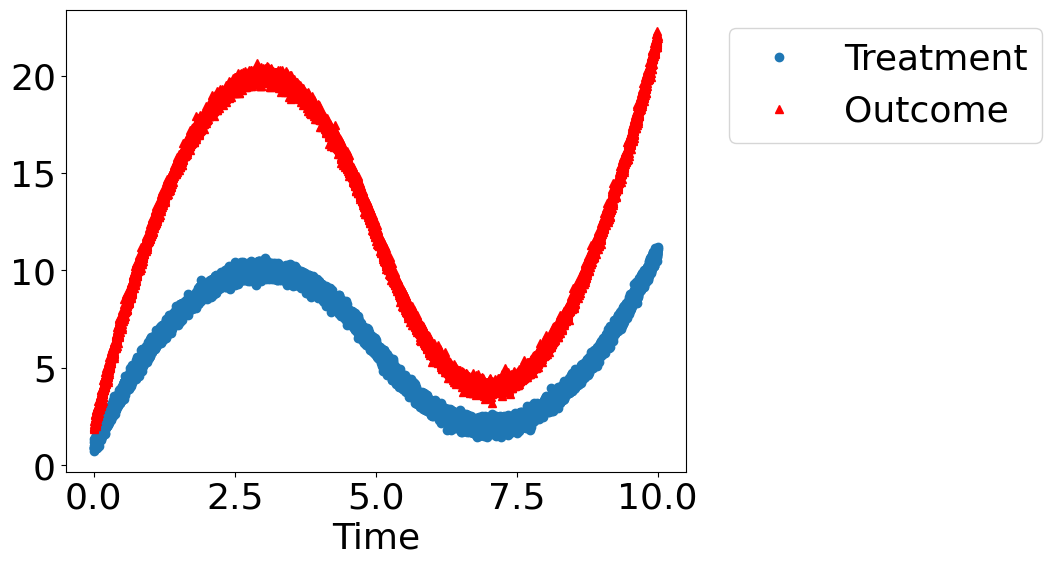

In [3]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

## Using DoWhy to resolve the mystery: *Does Treatment cause Outcome?*
### STEP 1: Model the problem as a causal graph
Initializing the causal model.

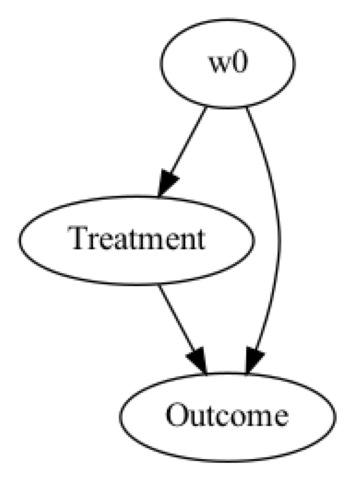

In [4]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

Showing the causal model stored in the local file "causal_model.png"

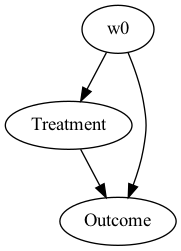

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [6]:
df

,Treatment,Outcome,w0,s
0,3.700972,7.285452,-2.264497,8.317385
1,10.163423,20.165819,4.058742,9.838792
2,2.398554,4.547218,-3.733632,6.483892
3,6.581902,12.852764,0.216842,4.945034
4,6.858515,13.235077,0.523075,1.135349
...,...,...,...,...
9995,2.941633,6.019636,-2.977005,5.988568
9996,4.930781,10.698629,-0.820018,0.804546
9997,9.390439,18.958498,3.412343,3.766588
9998,9.723147,19.793700,3.724534,2.475151


In [10]:
from dowhy.causal_graph import CausalGraph
from dowhy.causal_identifier import identify_effect


graph = CausalGraph(
            data_dict["treatment_name"],
            data_dict["outcome_name"],
            common_cause_names=data_dict["common_causes_names"],
            observed_node_names=df.columns.tolist(),
)

nx_graph = graph._graph

identified_estimand = identify_effect(nx_graph, action_nodes=data_dict["treatment_name"], outcome_nodes=data_dict["outcome_name"], observed_nodes=list(graph.get_all_nodes(include_unobserved=False)))
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### STEP 3: Estimate the causal effect

Once we have identified the estimand, we can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

/Users/rahulbshrestha/projects/dowhy/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Estimate is -0.001700952159950475


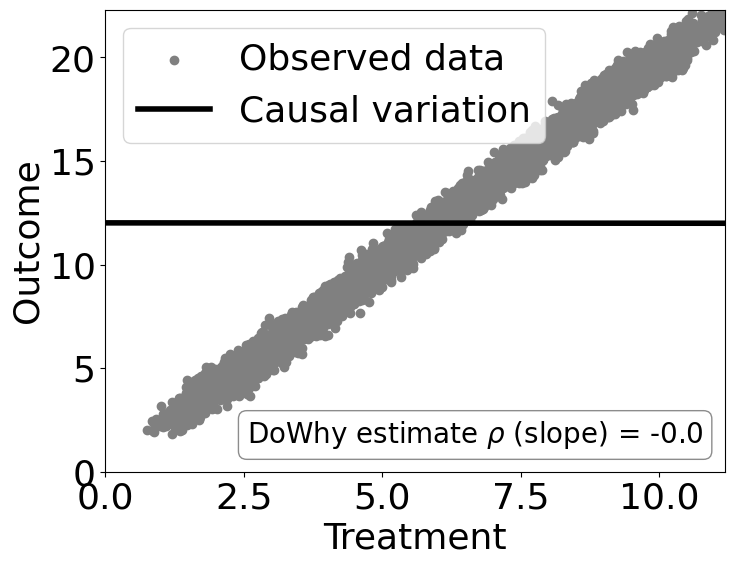

In [23]:
from dowhy.causal_estimator import estimate_effect

estimator_method = "linear_regression"
causal_estimator_class = dowhy.causal_estimators.get_class_object(estimator_method + "_estimator")
method_params = {}
extra_args = {}

causal_estimator = causal_estimator_class(
                    identified_estimand,
                    **method_params,
                    **extra_args,
                )

estimate  = estimate_effect(df, method_params=method_params, treatment=data_dict["treatment_name"], outcome=data_dict["outcome_name"], estimator=causal_estimator, identifier_name="backdoor", fit_estimator=True, )#effect_modifiers=effect_modifiers)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

/Users/rahulbshrestha/projects/dowhy/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Estimate is -0.001700952159950475


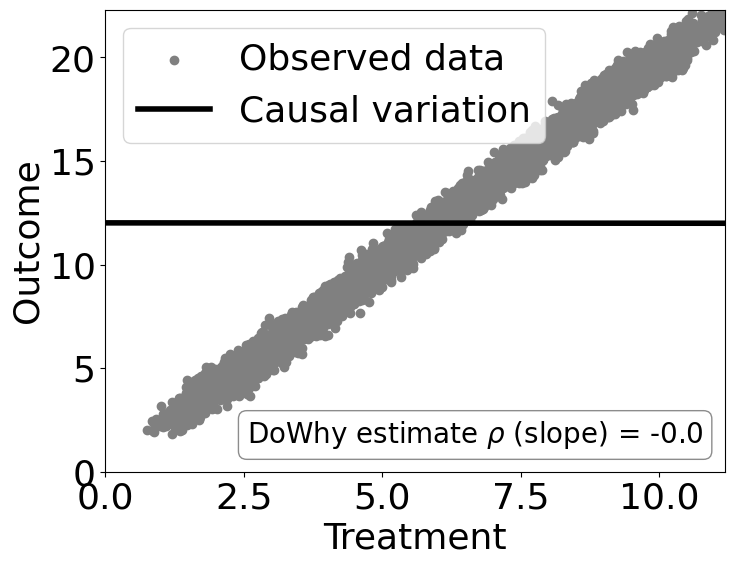

In [21]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [ ]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

### Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [ ]:
from dowhy.causal_refuters import refute_estimate

refuter_class = dowhy.causal_refuters.get_class_object("random_common_cause")

refuters = list()
refuters.append(refuter_class)

res_random = refute_estimate(data=df, 
                             treatment_name=data_dict["treatment_name"], 
                             target_estimand=identified_estimand,
                             outcome_name=data_dict["outcome_name"], 
                             identified_estimand=identified_estimand, 
                             estimate=estimate,
                             refuters=refuters)
print(res_random)

### Replacing treatment with a random (placebo) variable

In [ ]:
refuter_class = dowhy.causal_refuters.get_class_object("placebo_treatment_refuter")

refuters = list()
refuters.append(refuter_class)

res_placebo = refute_estimate(data=df, 
                             treatment_name=data_dict["treatment_name"], 
                             target_estimand=identified_estimand,
                             outcome_name=data_dict["outcome_name"], 
                             identified_estimand=identified_estimand, 
                             estimate=estimate,
                             refuters=refuters,
                             placebo_type="permute")
print(res_placebo)


### Removing a random subset of the data

In [ ]:
refuter_class = dowhy.causal_refuters.get_class_object("data_subset_refuter")

refuters = list()
refuters.append(refuter_class)

res_subset = refute_estimate(data=df, 
                             treatment_name=data_dict["treatment_name"], 
                             target_estimand=identified_estimand,
                             outcome_name=data_dict["outcome_name"], 
                             identified_estimand=identified_estimand, 
                             estimate=estimate,
                             refuters=refuters,
                             subset_fraction=0.9)
print(res_subset)

As you can see, our causal estimator is robust to simple refutations.